# Project price cars prediction
*KUBIK Aleksander - KOBANA Johan - JOUYIT Matthieu - DIA4*

Our problem : We want to be able to predict the price of a used car on the market, thanks to its different caracteristics

In [211]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from category_encoders import TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [212]:
cars = pd.read_csv('data.csv')
cars = cars.iloc[:, 1:]

In [213]:
cars.shape

(251079, 14)

In [214]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251079 entries, 0 to 251078
Data columns (total 14 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   brand                     251079 non-null  object 
 1   model                     251079 non-null  object 
 2   color                     250913 non-null  object 
 3   registration_date         251075 non-null  object 
 4   year                      251079 non-null  object 
 5   price_in_euro             251079 non-null  object 
 6   power_kw                  250945 non-null  object 
 7   power_ps                  250950 non-null  object 
 8   transmission_type         251079 non-null  object 
 9   fuel_type                 251079 non-null  object 
 10  fuel_consumption_l_100km  224206 non-null  object 
 11  fuel_consumption_g_km     251079 non-null  object 
 12  mileage_in_km             250927 non-null  float64
 13  offer_description         251078 non-null  o

In [215]:
#setting columns into numeric
cars['price_in_euro'] = pd.to_numeric(cars['price_in_euro'], errors='coerce')
cars['power_kw'] = pd.to_numeric(cars['power_kw'], errors='coerce')
cars['power_ps'] = pd.to_numeric(cars['power_ps'], errors='coerce')

In [216]:
#cleaning and setting datetime for *registration_date* and *year*
cars = cars[cars['registration_date'].str.match(r'^(0[1-9]|1[0-2])/[0-9]{4}$', na=False)]
cars['registration_date'] = pd.to_datetime(cars['registration_date'], format='%m/%Y')
cars['registration_date'].value_counts()

cars['year'] = pd.to_datetime(cars['year'], format='%Y')

In [217]:
#drop missing values
cars = cars.dropna(subset=['color'])

cars = cars.dropna(subset=['power_kw']) #delete also for power_ps because they have the same missing values

cars = cars.dropna(subset=['fuel_consumption_l_100km'])

cars = cars.dropna(subset=['mileage_in_km'])

cars = cars.drop(columns='offer_description')

In [218]:
cars['transmission_type'].value_counts()

transmission_type
Automatic         114123
Manual            108557
Unknown              770
Semi-automatic       283
Name: count, dtype: int64

In [219]:
cars['fuel_type'].value_counts() 

fuel_type
Petrol           132026
Diesel            78928
Hybrid            10312
LPG                1054
Electric            471
CNG                 414
Diesel Hybrid       375
Other                87
Hydrogen             38
Unknown              23
Ethanol               5
Name: count, dtype: int64

In [220]:
cars = cars[cars['transmission_type'] != 'Unknown']
valid_fuels = ['Petrol','Diesel','Hybrid','LPG','Electric']
cars = cars[cars['fuel_type'].isin(valid_fuels)]

In [221]:
#cleaning and setting float for *fuel_consumption_l_100km*
cars = cars[cars['fuel_consumption_l_100km'].str.contains('l/100 km', na=False)]

cars['fuel_consumption_l_100km'] = cars['fuel_consumption_l_100km'].str.extract(r'([\d,]+)')
cars['fuel_consumption_l_100km'] = cars['fuel_consumption_l_100km'].astype(str).str.replace(',', '.', regex=False)

cars['fuel_consumption_l_100km'] = pd.to_numeric(cars['fuel_consumption_l_100km'], errors='coerce')

In [222]:
#cleaning and setting float for *fuel_consumption_g_km*
cars = cars[cars['fuel_consumption_g_km'].str.contains('g/km', na=False)] 
cars['fuel_consumption_g_km'] = cars['fuel_consumption_g_km'].astype(str).str.replace(',', '.', regex=False)

cars['fuel_consumption_g_km'] = cars['fuel_consumption_g_km'].str.extract(r'([\d,]+)')

cars['fuel_consumption_g_km'] = pd.to_numeric(cars['fuel_consumption_g_km'], errors='coerce')
cars['fuel_consumption_g_km'] = cars['fuel_consumption_g_km'].replace(0, np.nan)

cars = cars.dropna(subset=['fuel_consumption_g_km'])

In [223]:
#shape and info after cleaning
print(cars.shape)
print(cars.info())

(197274, 13)
<class 'pandas.core.frame.DataFrame'>
Index: 197274 entries, 0 to 251076
Data columns (total 13 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   brand                     197274 non-null  object        
 1   model                     197274 non-null  object        
 2   color                     197274 non-null  object        
 3   registration_date         197274 non-null  datetime64[ns]
 4   year                      197274 non-null  datetime64[ns]
 5   price_in_euro             197274 non-null  float64       
 6   power_kw                  197274 non-null  float64       
 7   power_ps                  197274 non-null  float64       
 8   transmission_type         197274 non-null  object        
 9   fuel_type                 197274 non-null  object        
 10  fuel_consumption_l_100km  197274 non-null  float64       
 11  fuel_consumption_g_km     197274 non-null  float64       

In [224]:
cars.describe()

,registration_date,year,price_in_euro,power_kw,power_ps,fuel_consumption_l_100km,fuel_consumption_g_km,mileage_in_km
count,197274,197274,1.972740e+05,197274.000000,197274.000000,197274.000000,197274.000000,1.972740e+05
mean,2017-01-09 16:19:32.444417536,2016-08-04 02:15:24.334681856,2.603004e+04,124.247037,169.011157,6.146566,146.134133,8.183402e+04
min,1995-01-01 00:00:00,1995-01-01 00:00:00,1.490000e+02,10.000000,14.000000,0.000000,1.000000,0.000000e+00
25%,2014-05-01 00:00:00,2014-01-01 00:00:00,1.249000e+04,81.000000,110.000000,4.900000,119.000000,2.315125e+04
50%,2018-05-01 00:00:00,2018-01-01 00:00:00,1.998000e+04,110.000000,150.000000,5.700000,137.000000,6.500000e+04
75%,2020-11-01 00:00:00,2020-01-01 00:00:00,2.992350e+04,140.000000,190.000000,6.700000,164.000000,1.211248e+05
max,2023-07-01 00:00:00,2023-01-01 00:00:00,5.890500e+06,735.000000,999.000000,173.000000,999.000000,3.800000e+06
std,NaN,NaN,3.592503e+04,69.665203,94.690991,3.935359,46.203906,7.608103e+04


In [225]:
cars.isnull().sum()

brand                       0
model                       0
color                       0
registration_date           0
year                        0
price_in_euro               0
power_kw                    0
power_ps                    0
transmission_type           0
fuel_type                   0
fuel_consumption_l_100km    0
fuel_consumption_g_km       0
mileage_in_km               0
dtype: int64

In [226]:
cars.duplicated().sum()

np.int64(6506)

In [227]:
doublons = cars[cars.duplicated(keep=False)]
print(doublons)

             brand               model  color registration_date       year  \
173     alfa-romeo      Alfa Romeo 159   grey        2006-09-01 2006-01-01   
174     alfa-romeo      Alfa Romeo 159   grey        2006-09-01 2006-01-01   
562     alfa-romeo   Alfa Romeo Giulia  black        2016-10-01 2016-01-01   
566     alfa-romeo   Alfa Romeo Giulia  black        2016-10-01 2016-01-01   
956     alfa-romeo  Alfa Romeo Stelvio    red        2021-12-01 2021-01-01   
...            ...                 ...    ...               ...        ...   
251038       volvo           Volvo V60  black        2023-05-01 2023-01-01   
251039       volvo           Volvo V60  black        2023-05-01 2023-01-01   
251040       volvo           Volvo V60  black        2023-05-01 2023-01-01   
251051       volvo           Volvo V60  black        2023-05-01 2023-01-01   
251053       volvo           Volvo V60  black        2023-05-01 2023-01-01   

        price_in_euro  power_kw  power_ps transmission_type fue

In [228]:
cars = cars.drop_duplicates()

<Axes: >

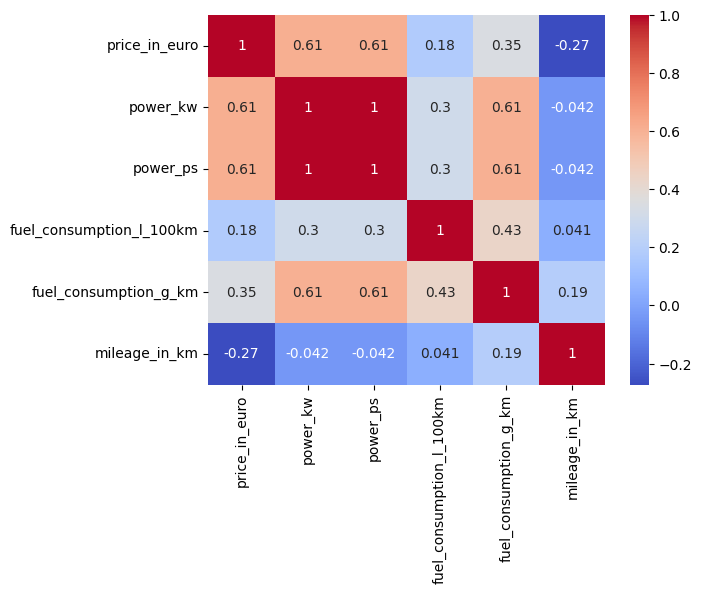

In [229]:
sns.heatmap(cars.corr(numeric_only=True), annot=True, cmap='coolwarm')

In [230]:
#drop of power_ps because it represents the same as power_kw 
cars.drop('power_ps', axis=1,inplace=True)

In [231]:
cars.reset_index(drop=True,inplace=True)
cars.head(10)

,brand,model,color,registration_date,year,price_in_euro,power_kw,transmission_type,fuel_type,fuel_consumption_l_100km,fuel_consumption_g_km,mileage_in_km
0,alfa-romeo,Alfa Romeo GTV,red,1995-10-01,1995-01-01,1300.0,148.0,Manual,Petrol,10.9,260.0,160500.0
1,alfa-romeo,Alfa Romeo Spider,black,1995-07-01,1995-01-01,4900.0,110.0,Manual,Petrol,9.5,225.0,189500.0
2,alfa-romeo,Alfa Romeo Spider,red,1996-04-01,1996-01-01,7900.0,110.0,Manual,Petrol,9.5,225.0,47307.0
3,alfa-romeo,Alfa Romeo 145,red,1996-12-01,1996-01-01,3500.0,110.0,Manual,Petrol,8.8,210.0,230000.0
4,alfa-romeo,Alfa Romeo 164,black,1996-07-01,1996-01-01,5500.0,132.0,Manual,Petrol,13.4,320.0,168000.0
5,alfa-romeo,Alfa Romeo Spider,black,1996-07-01,1996-01-01,8990.0,141.0,Manual,Petrol,11.0,265.0,168600.0
6,alfa-romeo,Alfa Romeo Spider,black,1996-01-01,1996-01-01,6976.0,110.0,Manual,Petrol,9.2,220.0,99000.0
7,alfa-romeo,Alfa Romeo Spider,silver,1996-02-01,1996-01-01,5499.0,141.0,Manual,Petrol,11.1,265.0,157000.0
8,alfa-romeo,Alfa Romeo Spider,silver,1996-10-01,1996-01-01,8499.0,110.0,Manual,Petrol,9.5,225.0,15550.0
9,alfa-romeo,Alfa Romeo GTV,grey,1997-05-01,1997-01-01,15800.0,162.0,Manual,Petrol,11.7,125.0,177000.0


array([[<Axes: title={'center': 'registration_date'}>,
        <Axes: title={'center': 'year'}>,
        <Axes: title={'center': 'price_in_euro'}>],
       [<Axes: title={'center': 'power_kw'}>,
        <Axes: title={'center': 'fuel_consumption_l_100km'}>,
        <Axes: title={'center': 'fuel_consumption_g_km'}>],
       [<Axes: title={'center': 'mileage_in_km'}>, <Axes: >, <Axes: >]],
      dtype=object)

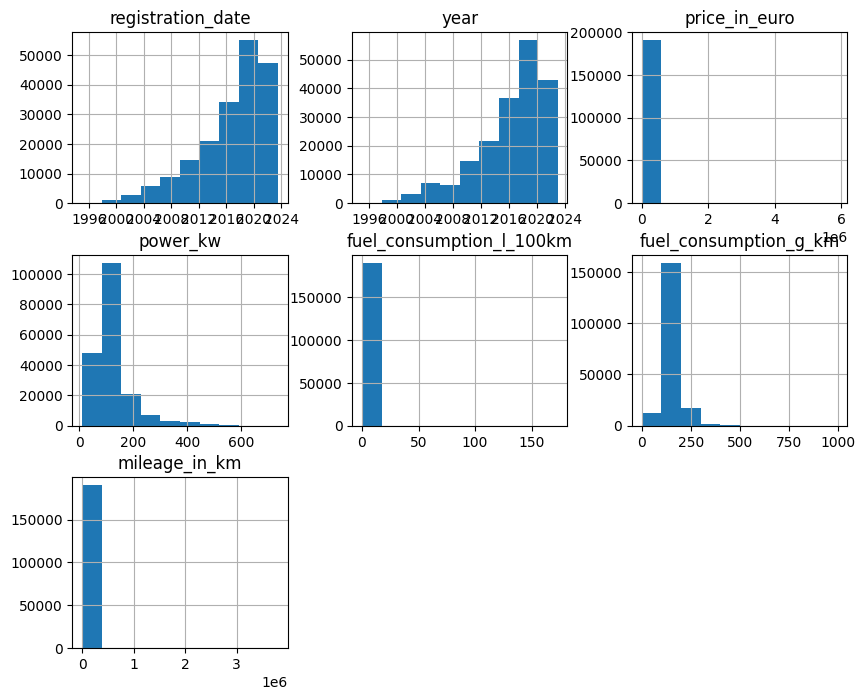

In [232]:
cars.hist(figsize=(10,8))

<Axes: xlabel='year'>

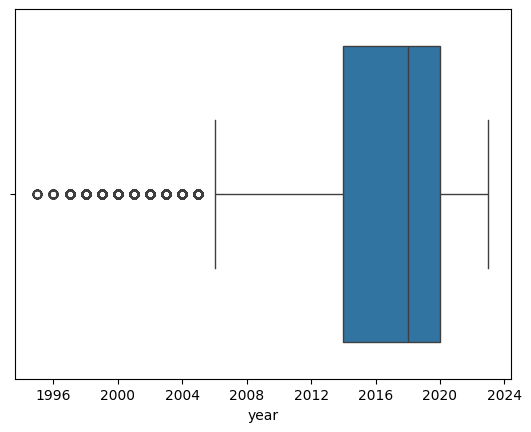

In [233]:
sns.boxplot(data=cars, x='year')

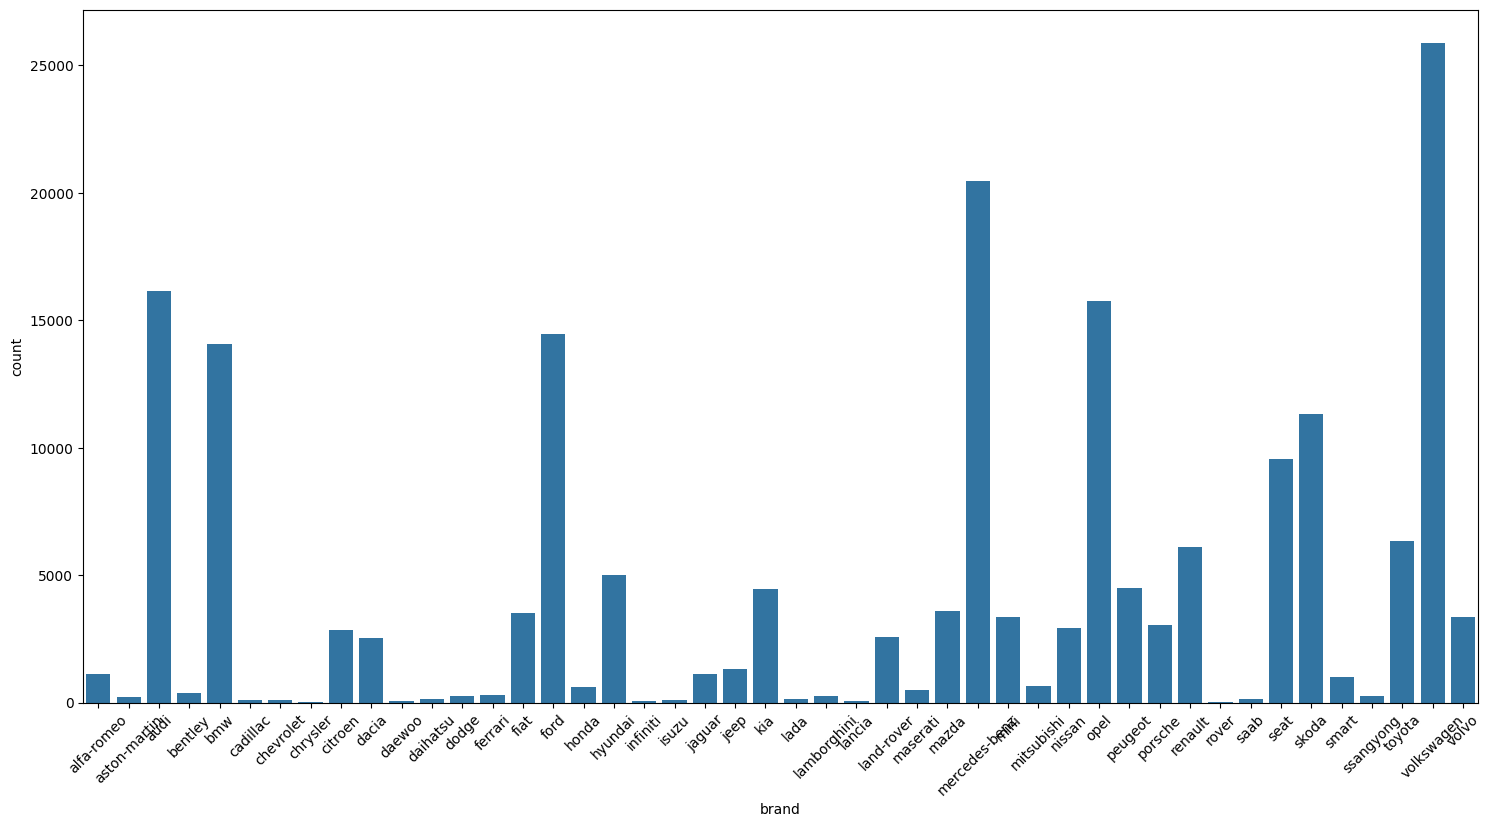

In [234]:
#noumber of cars per brand
plt.figure(figsize=(18,9))  
sns.countplot(data=cars, x='brand')
plt.xticks(rotation=45)
plt.show()

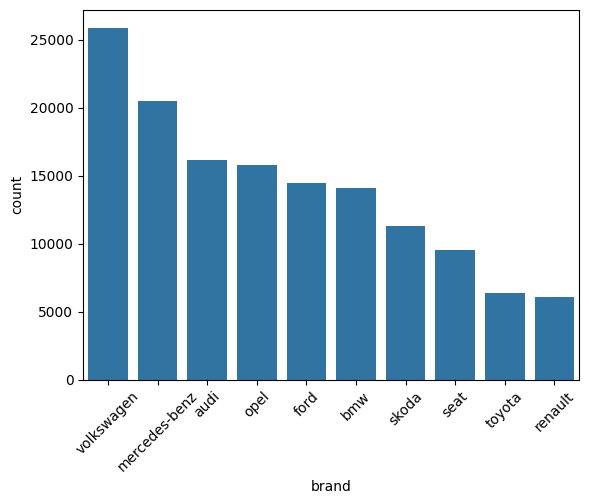

In [235]:
#top 10 most present brands
top_brands = cars['brand'].value_counts().nlargest(10).index
sns.countplot(data=cars[cars['brand'].isin(top_brands)], x='brand', order=top_brands)
plt.xticks(rotation=45)
plt.show()

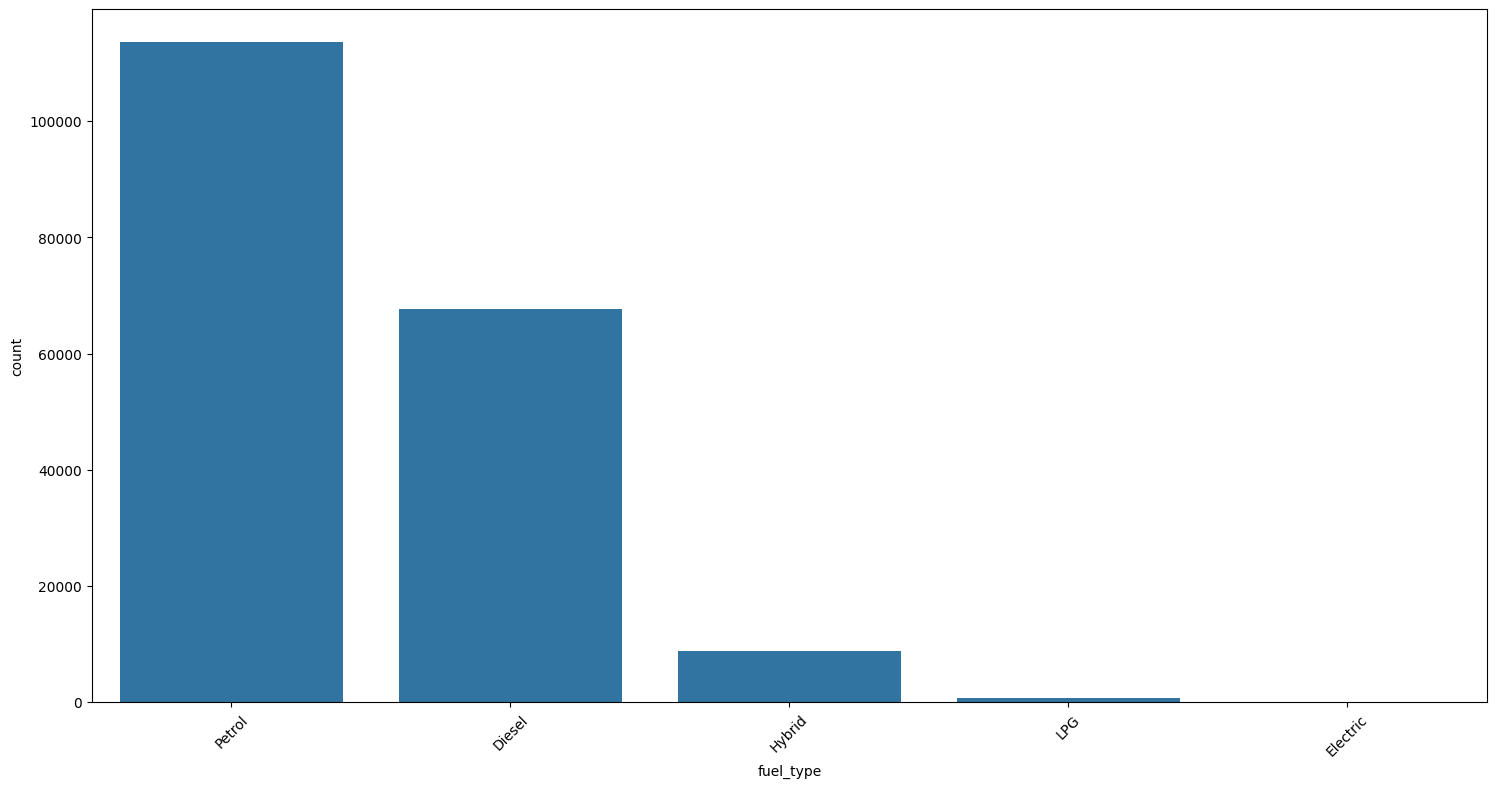

In [236]:
plt.figure(figsize=(18,9))  
sns.countplot(data=cars, x='fuel_type')
plt.xticks(rotation=45)
plt.show()

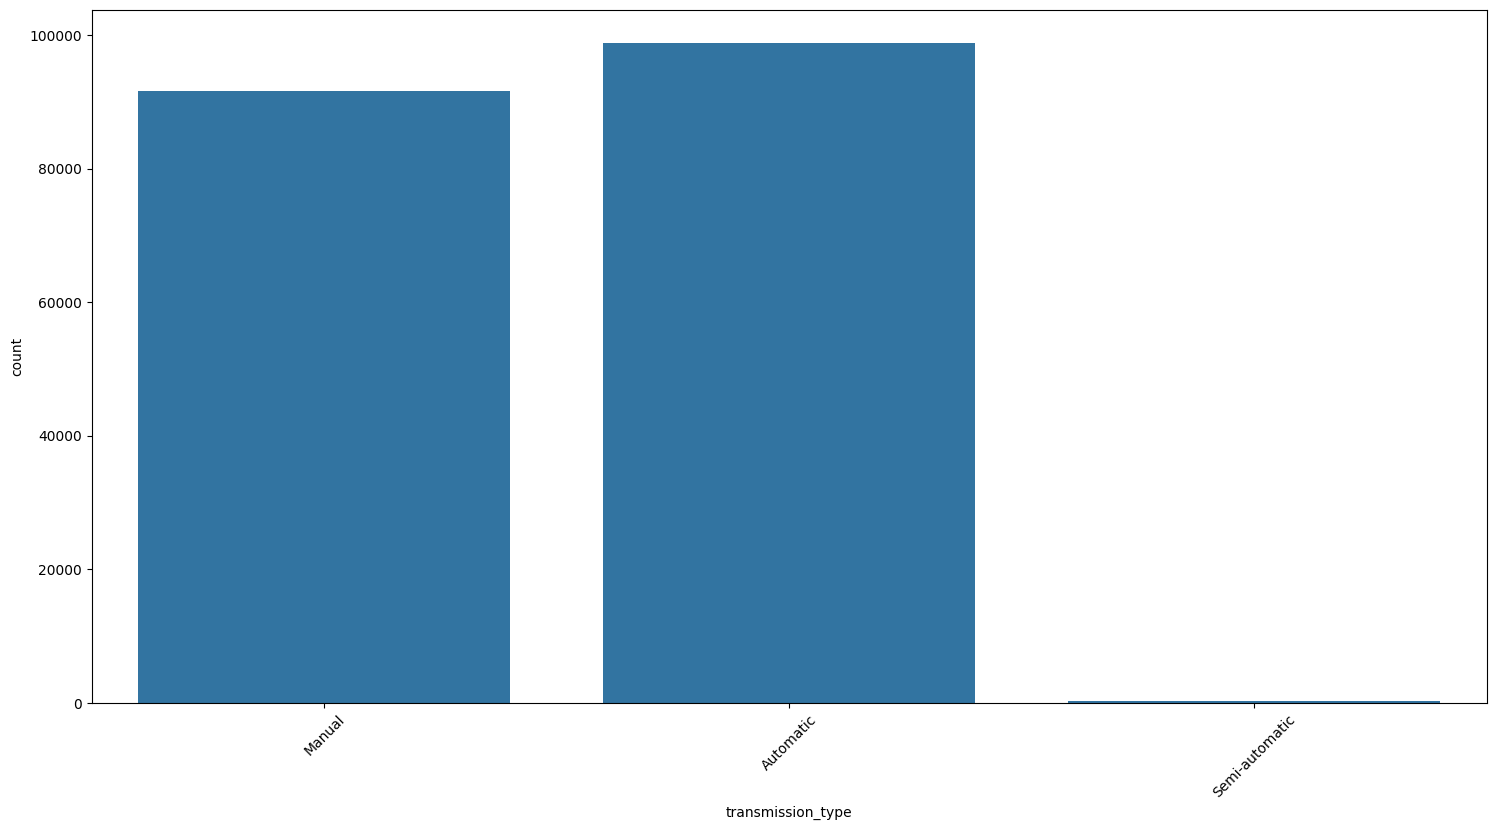

In [237]:
plt.figure(figsize=(18,9))  
sns.countplot(data=cars, x='transmission_type')
plt.xticks(rotation=45)
plt.show()

In [238]:
#outlier for price
cars.drop(cars['price_in_euro'].idxmax(),inplace=True)

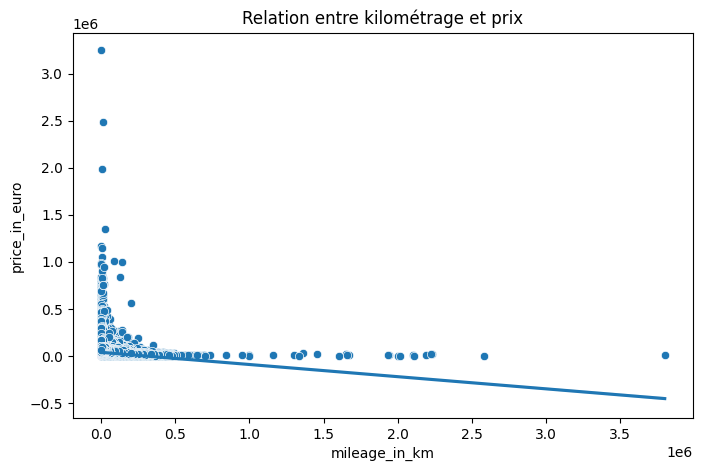

In [239]:
plt.figure(figsize=(8,5))
sns.scatterplot(data=cars, x='mileage_in_km', y='price_in_euro')
sns.regplot(data=cars, x='mileage_in_km', y='price_in_euro', scatter=False)
plt.title('Relation entre kilométrage et prix')
plt.show()


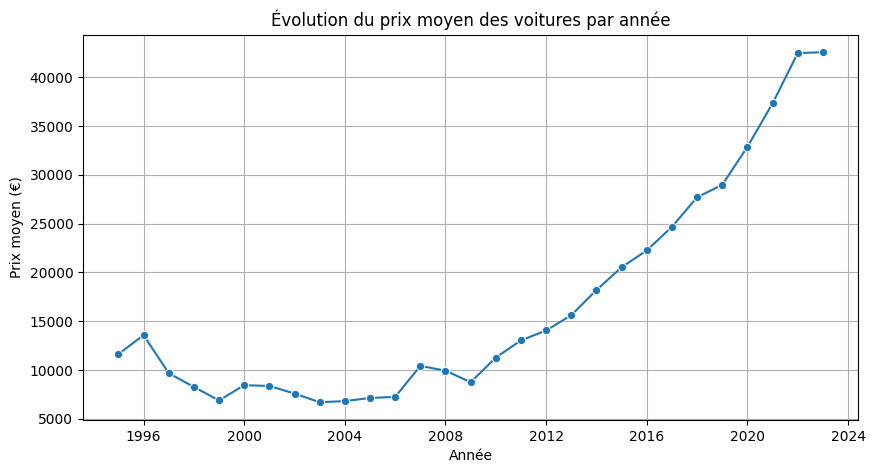

In [240]:
price_by_year = cars.groupby('year')['price_in_euro'].mean().reset_index()
plt.figure(figsize=(10,5))
sns.lineplot(data=price_by_year, x='year', y='price_in_euro', marker='o')
plt.title("Évolution du prix moyen des voitures par année")
plt.xlabel("Année")
plt.ylabel("Prix moyen (€)")
plt.grid(True)
plt.show()

In [241]:
#feature engineering
cars['age'] = 2025 - cars['year'].dt.year
cars['registration_year'] = cars['registration_date'].dt.year
cars = cars.drop(columns=['year', 'registration_date'])

cars['power_efficiency'] = cars['power_kw'] / cars['fuel_consumption_l_100km']
cars['price_per_km'] = cars['price_in_euro'] / cars['mileage_in_km']


In [242]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
Index: 190767 entries, 0 to 190767
Data columns (total 14 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   brand                     190767 non-null  object 
 1   model                     190767 non-null  object 
 2   color                     190767 non-null  object 
 3   price_in_euro             190767 non-null  float64
 4   power_kw                  190767 non-null  float64
 5   transmission_type         190767 non-null  object 
 6   fuel_type                 190767 non-null  object 
 7   fuel_consumption_l_100km  190767 non-null  float64
 8   fuel_consumption_g_km     190767 non-null  float64
 9   mileage_in_km             190767 non-null  float64
 10  age                       190767 non-null  int32  
 11  registration_year         190767 non-null  int32  
 12  power_efficiency          190767 non-null  float64
 13  price_per_km              190767 non-null  float6

In [243]:
cars.head()

,brand,model,color,price_in_euro,power_kw,transmission_type,fuel_type,fuel_consumption_l_100km,fuel_consumption_g_km,mileage_in_km,age,registration_year,power_efficiency,price_per_km
0,alfa-romeo,Alfa Romeo GTV,red,1300.0,148.0,Manual,Petrol,10.9,260.0,160500.0,30,1995,13.577982,0.008100
1,alfa-romeo,Alfa Romeo Spider,black,4900.0,110.0,Manual,Petrol,9.5,225.0,189500.0,30,1995,11.578947,0.025858
2,alfa-romeo,Alfa Romeo Spider,red,7900.0,110.0,Manual,Petrol,9.5,225.0,47307.0,29,1996,11.578947,0.166994
3,alfa-romeo,Alfa Romeo 145,red,3500.0,110.0,Manual,Petrol,8.8,210.0,230000.0,29,1996,12.500000,0.015217
4,alfa-romeo,Alfa Romeo 164,black,5500.0,132.0,Manual,Petrol,13.4,320.0,168000.0,29,1996,9.850746,0.032738


In [244]:
# ---------------------------
# 1) Colonnes concernées
# ---------------------------

target = "price_in_euro"

target_encoding_cols = ["brand", "model"] #because too many different values
one_hot_cols = ["color", "transmission_type", "fuel_type"]

# ---------------------------
# 2) Preprocessors
# ---------------------------

# Target Encoding - mean of the price per category
target_encoder = TargetEncoder(cols=target_encoding_cols)

# One-Hot Encoding
onehot_encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

# ---------------------------
# 3) ColumnTransformer combinant tout
# ---------------------------

preprocessor = ColumnTransformer(
    transformers=[
        ("target_enc", target_encoder, target_encoding_cols),
        ("onehot", onehot_encoder, one_hot_cols)
    ],
    remainder="passthrough"  # garde les colonnes numériques comme elles sont
)

# ---------------------------
# 4) Pipeline complet
# ---------------------------

pipeline = Pipeline(steps=[
    ("preprocessing", preprocessor)
])

# ---------------------------
# 5) Fit/transform
# ---------------------------

X = cars.drop(columns=[target])
y = cars[target]

X_processed = pipeline.fit_transform(X, y)

X_processed_df = pd.DataFrame(X_processed)

print(X_processed_df.head())


             0             1    2    3    4    5    6    7    8    9   ...  \
0  32669.355735  21415.833087  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
1  32669.355735  12979.342966  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
2  32669.355735  12979.342966  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
3  32669.355735  22547.105219  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
4  32669.355735  23240.506187  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   

    22   23     24    25     26        27    28      29         30        31  
0  0.0  1.0  148.0  10.9  260.0  160500.0  30.0  1995.0  13.577982  0.008100  
1  0.0  1.0  110.0   9.5  225.0  189500.0  30.0  1995.0  11.578947  0.025858  
2  0.0  1.0  110.0   9.5  225.0   47307.0  29.0  1996.0  11.578947  0.166994  
3  0.0  1.0  110.0   8.8  210.0  230000.0  29.0  1996.0  12.500000  0.015217  
4  0.0  1.0  132.0  13.4  320.0  168000.0  29.0  1996.0   9.850746  0.032738  

[5 rows x 32 columns]
